In [49]:
import numpy as np
import sys
from random import randint
from math import sqrt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

In [50]:
#Method to calculate Eucledian distance between two clusters
def eucledian_distance(data,centroid):
    distance = 0
    for i in range(len(data)):
        distance += ((data[i] - centroid[i]) ** 2)
    
    return float(sqrt(distance))

In [51]:
#Method to check if both data points belong to the same class
def check_classes(a, b):
    if a == b:
        return 1
    return 0

In [52]:
#Method to populate the incidence matrix for external index calculation  
def get_incidence_matrix(classes):
    incidence_matrix = np.zeros((len(classes),len(classes)))
    print(incidence_matrix.shape)
    for i in range(len(classes)):
        for j in range(len(classes)):
            val =check_classes(classes[i], classes[j])
            incidence_matrix[i][j] = val
    return incidence_matrix

In [53]:
#Method to get the parameters needed from the indicence matrix to calculate external index
def get_count(P, C):
    m11 = m00 = m10 = m01 = 0.0
    for i in range(len(P)):
        for j in range(len(P)):
            if P[i][j] == C[i][j]:
                if P[i][j] == 1:
                    m11 += 1
                else:
                    m00 += 1
            else:
                if P[i][j] == 1:
                    m10 += 1
                else:
                    m01 += 1
                
    return m11, m00, m10, m01


In [54]:
#Method to plot clusters and their centroids         
def plot_points(data, clustered_class):
    plt.figure(figsize=[10,5])
    legend = list()
    classes = np.unique(clustered_class)
    colors = cm.Set2(np.linspace(0,1,len(classes)))
    for i in range(len(classes)):
        cluster_data = data[np.where(clustered_class[:]==classes[i])]
        legend.append(plt.scatter(cluster_data[:,0],cluster_data[:,1], c=colors[i], s=10))
    if classes[0] == 0:
        classes[0] = -1
    plt.legend(legend,classes.astype(int))
    plt.title("DBSCAN")
    plt.show()

In [55]:
#Method to append all data points less than eps distance away from the input data point into neighbor_points
def region_query(row1):
    neighbor_points = []
    for row2 in range(len(data)):
        if(eucledian_distance(data[row1],data[row2]) <= eps):
            neighbor_points.append(row2)
    return neighbor_points

#Method to check if the row has at least minpts number of neighbor points
def check_min_points(row,neighbor_points):
    if len(neighbor_points) >= minpts:
        return True
    return False

#Method to check if a data point is already present in a cluster
def check_in_cluster(point):
    for key in all_clusters.keys():
        if point in all_clusters[key]:
            return True
    return False

Cluster 1: [  3   6 346 353 365]
Cluster 2: [ 15  16  19  21  32  33  34  51 133 145 189 237]
Cluster 3: [ 24  28  31  47  69  71  73  74  75  77  79  80  81  84  85  87  88  91
  92  93  94  95  96  97  99 100 101 102 103 104 105 109 110 112 113 114
 116 118 127 134 135 136 137 140 142 144 146 149 152 154 155 159 161 163
 165 166 167 171 173 174 181 182 184 185 192 193 195 197 199 200 201 207
 208 212 221 222 223 224 225 226 229 230 231 232 233 234 236 239 240 241
 243 245 251 253 254 255 256 257 258 259 263 264 265 266 267 269 270 272
 273 276 277 278 279 280 281 284 285 286 287 288 290 291 297 298 299 300
 308 309 313 314 316 317 320 321 322 323 324 326 327 328 329 330 336 340
 341 351 352 357 359 364 368 370 381]
Cluster 4: [ 67 148 153]
Cluster 5: [343 345 348 371]
Cluster 6: [282 332 337 379]
(386, 386)
(386, 386)
Jaccard: 0.20164510077444803
Rand: 0.5544309914360117


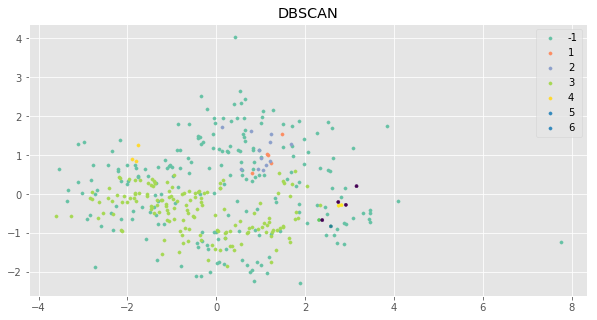

In [62]:
import pandas as pd
#Method to add the data point to the specified cluster
def add_to_cluster(cluster_id, row):
    if cluster_id in all_clusters.keys():
        all_clusters[cluster_id].append(row)
    else:
        all_clusters[cluster_id] = []
        all_clusters[cluster_id].append(row)

#Method to expand the cluster of the input data point
def expand_cluster(row,neighbor_points,cluster_id):
    add_to_cluster(cluster_id, row)
    for pt in neighbor_points:
        if pt not in visited:
            visited.append(pt)
            new_neighbor_pts = region_query(pt)
            if(check_min_points(pt,new_neighbor_pts)):
                neighbor_points = list(set(neighbor_points).union(set(new_neighbor_pts)))
                expand_cluster(row,neighbor_points,cluster_id)
                # print(neighbor_points)
        if not check_in_cluster(pt):
            add_to_cluster(cluster_id, pt)
            

data = pd.read_csv("cho.txt",header=None, sep='\t')
data = data.values
gene = data[:, 2:]
ground_truth = data[:, 1]

classes = len(np.unique(ground_truth))
data = np.delete(data,[0,1],axis=1)

eps = float(1.03)
minpts = int(3)


visited = []
noise = []
all_clusters = {}
cluster_id = 0

for row in range(len(data)):
    if row not in visited:    
        visited.append(row)
        neighbor_points = region_query(row)
        if(check_min_points(row,neighbor_points)):
            cluster_id+=1
            expand_cluster(row,neighbor_points,cluster_id)
        else:
            noise.append(row)

clustered_class = np.zeros(ground_truth.shape)
i = 0
for genes in list(all_clusters):
    class_list = np.unique(np.asarray(all_clusters[genes])).astype(int)
    i += len(class_list)
    print('Cluster '+str(genes)+': '+str(class_list))
    clustered_class[class_list] = genes

ground_truth_matrix = get_incidence_matrix(ground_truth)
cluster_matrix = get_incidence_matrix(clustered_class.astype(int))
m11, m00, m10, m01 = get_count(ground_truth_matrix, cluster_matrix)

print('Jaccard: '+str(m11/(m11 + m10 + m01)))
print('Rand: '+str((m11 + m00)/(m11 + m00 + m10 + m01)))

pca_data = PCA(n_components=2).fit_transform(data)
plot_points(pca_data, clustered_class)

Cluster 1: [   0    1    2 ... 1097 1098 1099]
(1100, 1100)
(1100, 1100)
Jaccard: 0.28512396694214875
Rand: 0.28512396694214875


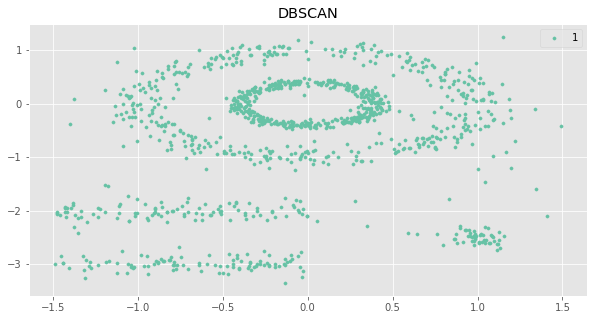

In [61]:
import pandas as pd
#Method to add the data point to the specified cluster
def add_to_cluster(cluster_id, row):
    if cluster_id in all_clusters.keys():
        all_clusters[cluster_id].append(row)
    else:
        all_clusters[cluster_id] = []
        all_clusters[cluster_id].append(row)

#Method to expand the cluster of the input data point
def expand_cluster(row,neighbor_points,cluster_id):
    add_to_cluster(cluster_id, row)
    for pt in neighbor_points:
        if pt not in visited:
            visited.append(pt)
            new_neighbor_pts = region_query(pt)
            if(check_min_points(pt,new_neighbor_pts)):
                neighbor_points = list(set(neighbor_points).union(set(new_neighbor_pts)))
                expand_cluster(row,neighbor_points,cluster_id)
                # print(neighbor_points)
        if not check_in_cluster(pt):
            add_to_cluster(cluster_id, pt)
            
#filename = raw_input("Enter filename: ")
data = pd.read_csv("dbscan_tab_seperated.txt",header=None, sep='\t')
data = data.values
gene = data[:, 2:]
ground_truth = data[:, 1]

classes = len(np.unique(ground_truth))
data = np.delete(data,[0,1],axis=1)

eps = float(1)
minpts = int(3)


visited = []
noise = []
all_clusters = {}
cluster_id = 0

for row in range(len(data)):
    if row not in visited:    
        visited.append(row)
        neighbor_points = region_query(row)
        if(check_min_points(row,neighbor_points)):
            cluster_id+=1
            expand_cluster(row,neighbor_points,cluster_id)
        else:
            noise.append(row)

clustered_class = np.zeros(ground_truth.shape)
i = 0
for genes in list(all_clusters):
    class_list = np.unique(np.asarray(all_clusters[genes])).astype(int)
    i += len(class_list)
    print('Cluster '+str(genes)+': '+str(class_list))
    clustered_class[class_list] = genes

ground_truth_matrix = get_incidence_matrix(ground_truth)
cluster_matrix = get_incidence_matrix(clustered_class.astype(int))
m11, m00, m10, m01 = get_count(ground_truth_matrix, cluster_matrix)

print('Jaccard: '+str(m11/(m11 + m10 + m01)))
print('Rand: '+str((m11 + m00)/(m11 + m00 + m10 + m01)))

#pca_data = PCA(n_components=2).fit_transform(data)
plot_points(data, clustered_class)